In [475]:
import pandas as pd
import matplotlib.pyplot as plt

#  Load Pollution Data 
pollution = pd.read_csv('data/shanghai.csv', parse_dates=['date'], dayfirst=False)  # US-style M/D/Y
pollution['date'] = pd.to_datetime(pollution['date'], format='%m/%d/%y')
pollution.set_index('date', inplace=True)

# Confirm date range
print(f"Pollution data from {pollution.index.min().date()} to {pollution.index.max().date()}")

#  Load Coal Index Data 
coal = pd.read_csv('data/china-coal.csv', parse_dates=['date'])
coal['date'] = pd.to_datetime(coal['date'])  # ISO format assumed here
coal.set_index('date', inplace=True)

# Confirm date range
print(f"Coal index data from {coal.index.min().date()} to {coal.index.max().date()}")

/var/folders/n0/qhjx1vrd1c1b846x7pqgmbg40000gn/T/ipykernel_14390/4090026733.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pollution = pd.read_csv('data/shanghai.csv', parse_dates=['date'], dayfirst=False)  # US-style M/D/Y


Pollution data from 2014-01-01 to 2025-07-11
Coal index data from 2004-04-30 to 2025-05-31


/var/folders/n0/qhjx1vrd1c1b846x7pqgmbg40000gn/T/ipykernel_14390/4090026733.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  coal = pd.read_csv('data/china-coal.csv', parse_dates=['date'])


In [476]:
pollution.columns = ["pm25", "pm10", "o3", "no2", "so2", "co"]

coal.columns = ['coalindx']

In [477]:
pollution_vars = ["pm25", "pm10", "o3", "no2", "so2", "co"]

In [478]:
for col in pollution.columns:
    pollution[col] = pd.to_numeric(pollution[col], errors='coerce')

# Monthly resampling of daily pollution data
monthly_pollution = pollution.resample('M').mean()

/var/folders/n0/qhjx1vrd1c1b846x7pqgmbg40000gn/T/ipykernel_14390/2658814368.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_pollution = pollution.resample('M').mean()


In [479]:
pollution_monthly = pollution.resample("M").mean()

/var/folders/n0/qhjx1vrd1c1b846x7pqgmbg40000gn/T/ipykernel_14390/2086014946.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pollution_monthly = pollution.resample("M").mean()


In [480]:
coal.index = coal.index.to_period('M').to_timestamp()
monthly_pollution.index = monthly_pollution.index.to_period('M').to_timestamp()

In [481]:
# Merge on full date range from 2014 to 2025
data = pd.merge(coal, monthly_pollution, left_index=True, right_index=True, how='left')

In [482]:
data.dropna(inplace=True)

In [483]:
target = 'coalindx'
exog_vars = [col for col in data.columns if col != target]

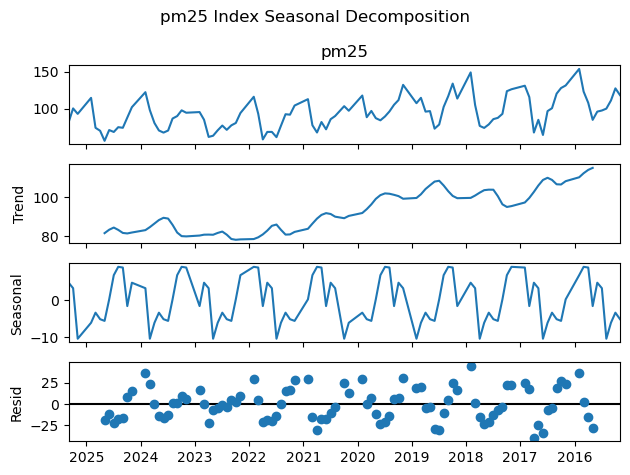

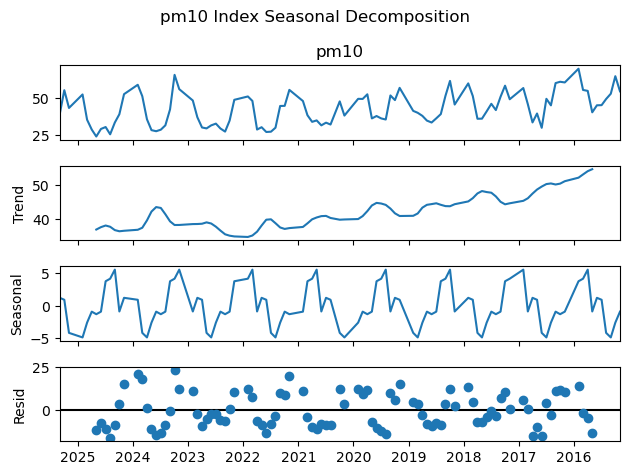

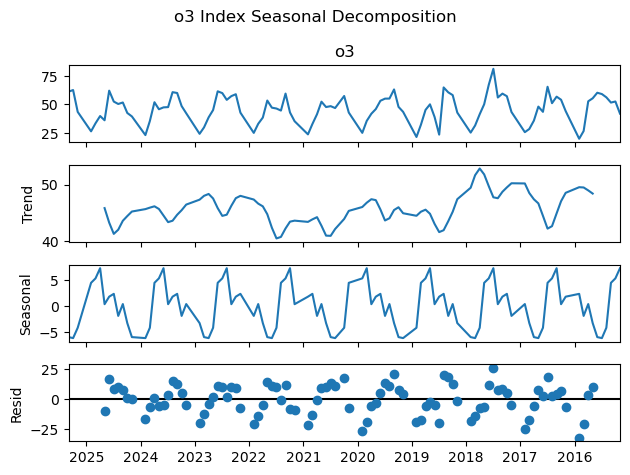

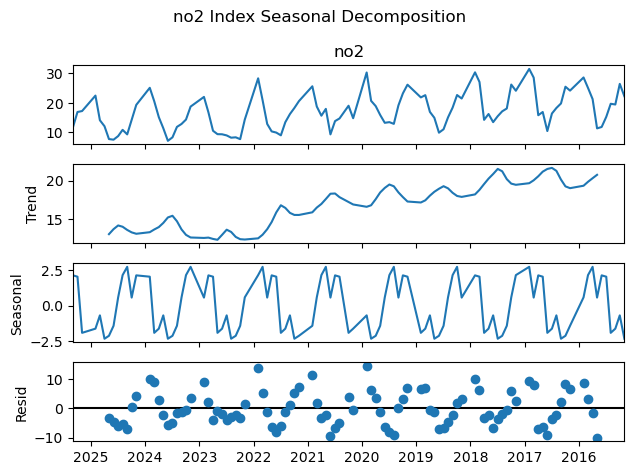

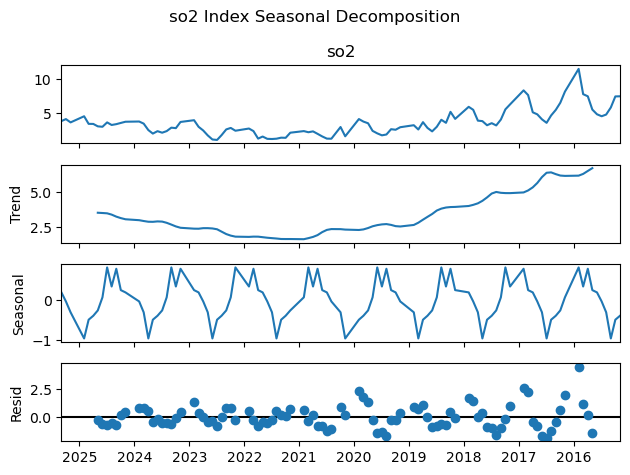

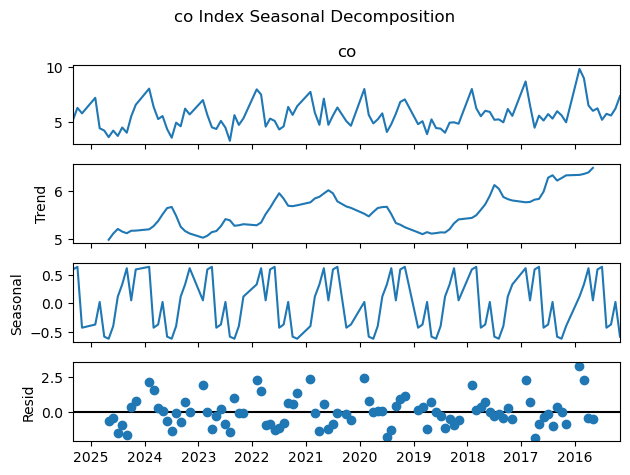

In [484]:
from statsmodels.tsa.seasonal import seasonal_decompose

for col in pollution_vars:
    decomp = seasonal_decompose(data[col], model='additive', period=12)
    decomp.plot()
    plt.suptitle(f"{col} Index Seasonal Decomposition")
    plt.tight_layout()
    plt.show()

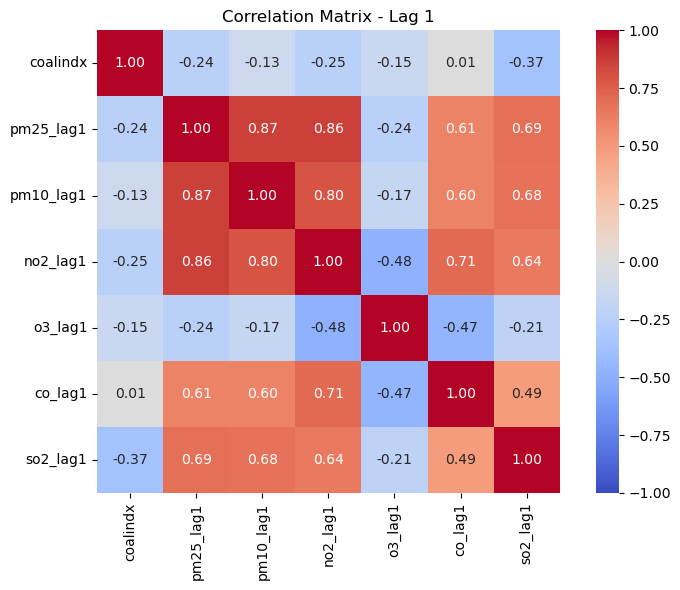

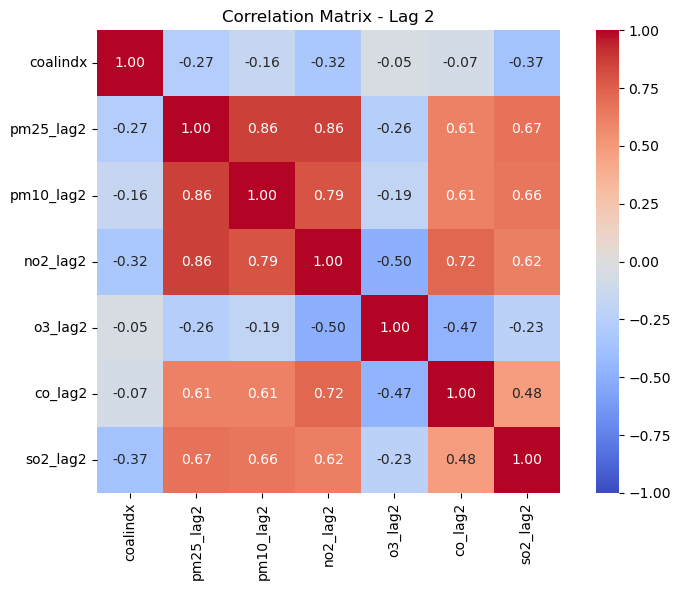

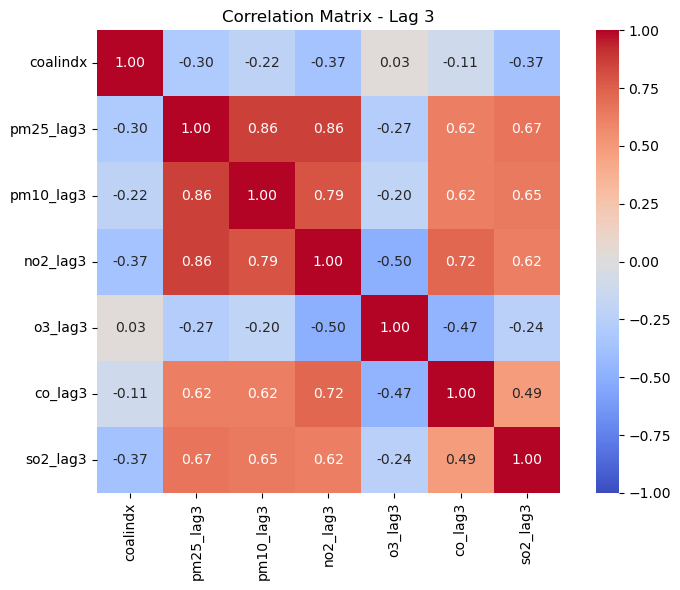

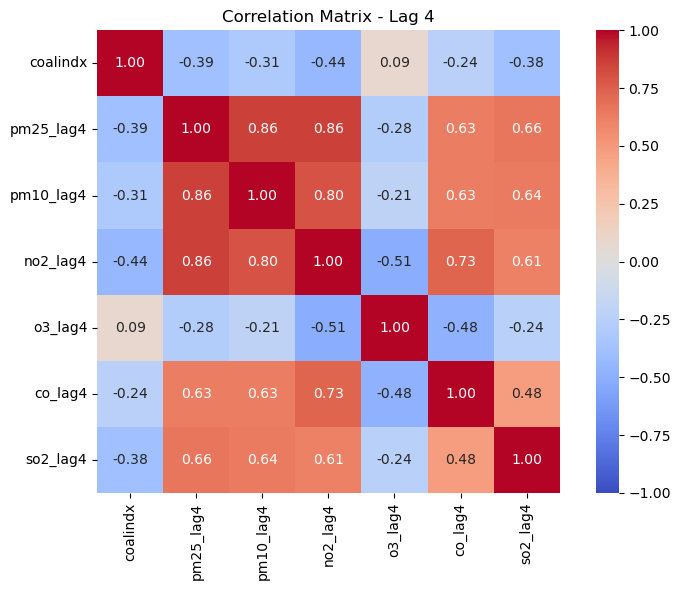

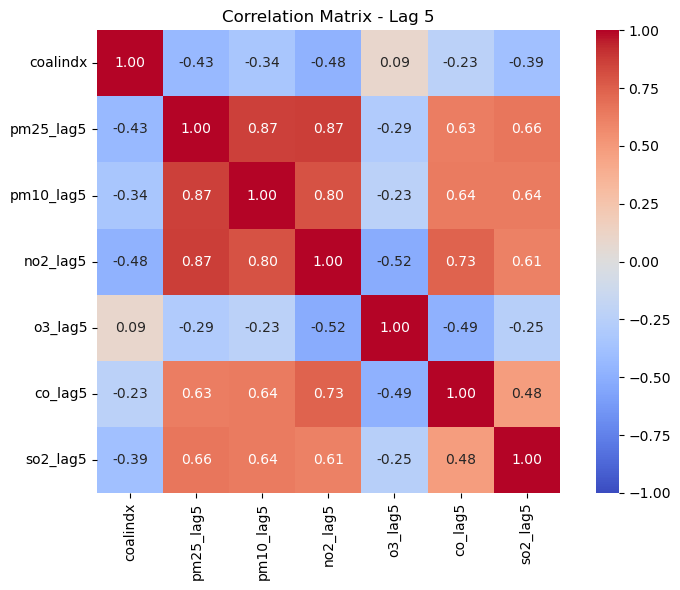

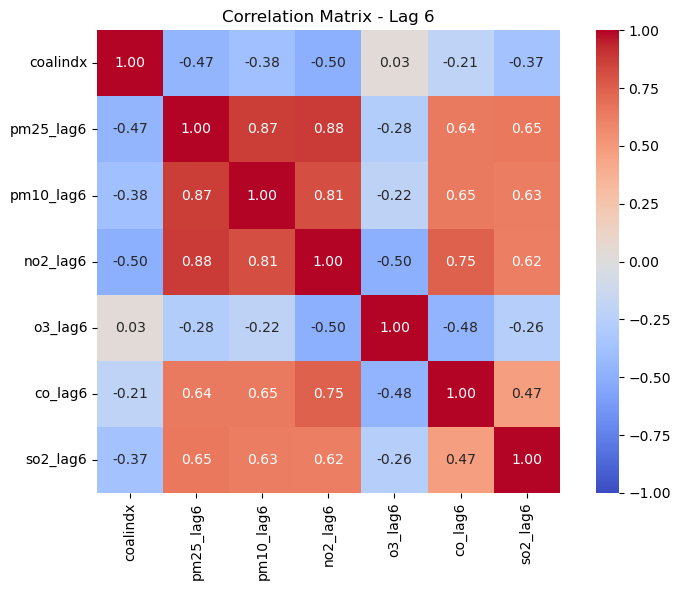

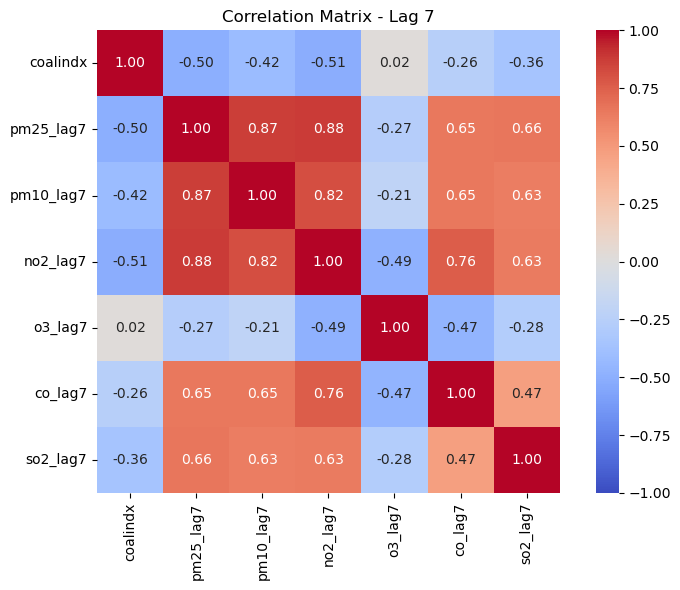

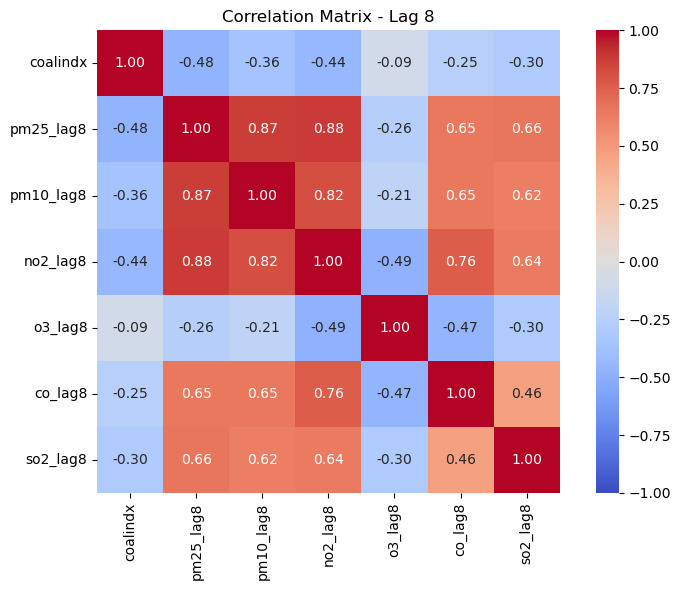

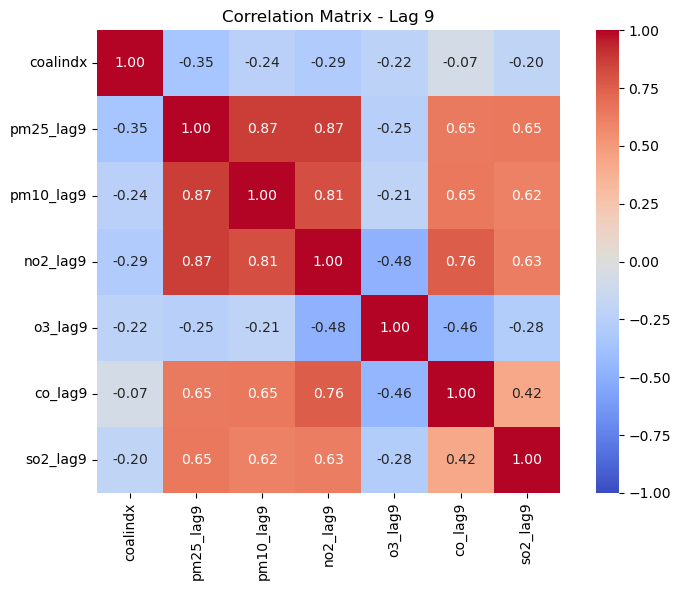

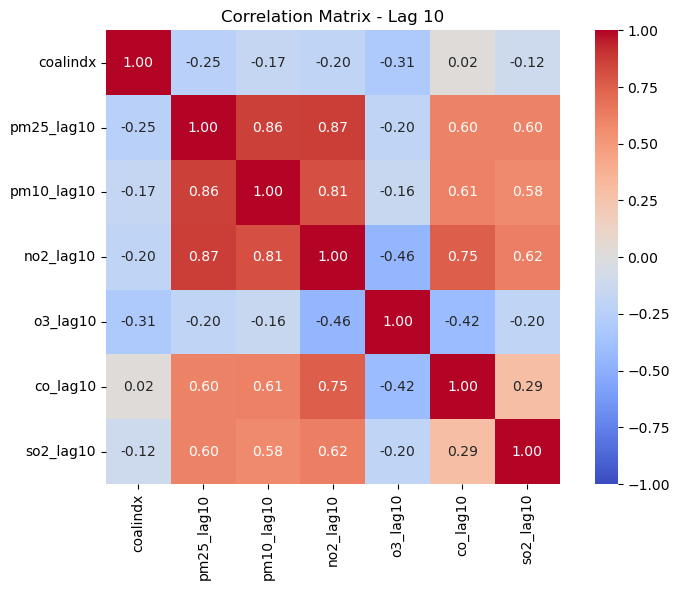

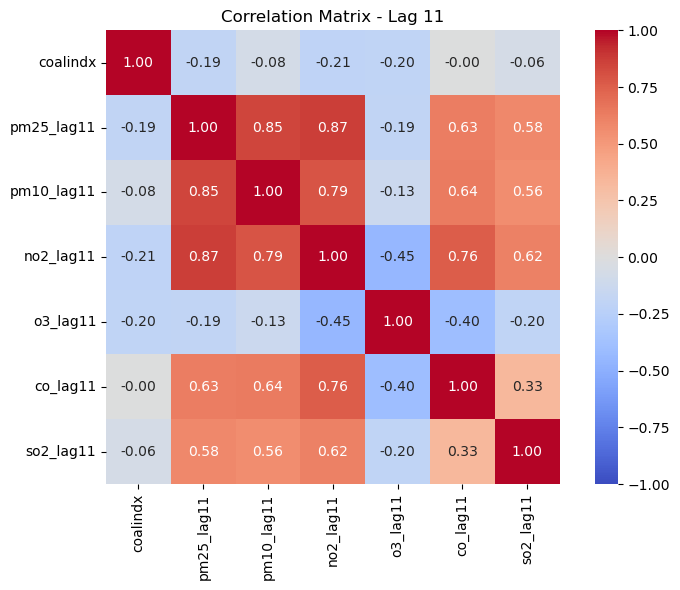

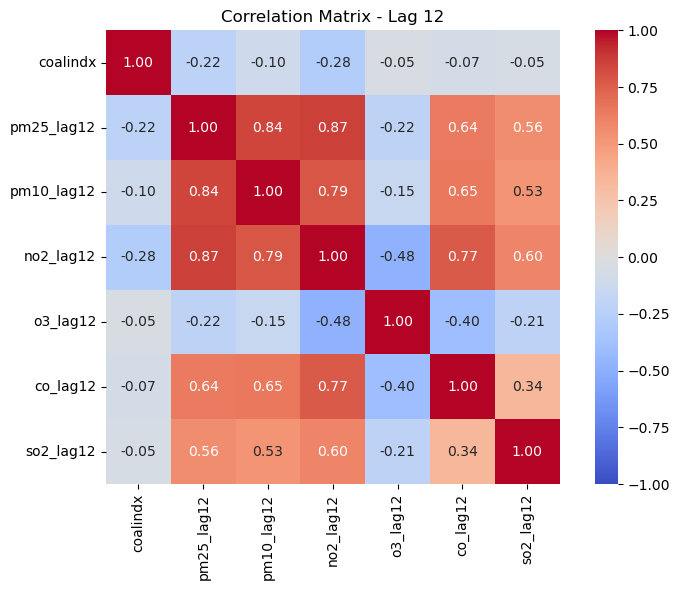

In [485]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Desired order from image
base_vars = ['coalindx', 'pm25', 'pm10', 'no2', 'o3', 'co', 'so2']
pollutants = base_vars[1:]  # exclude 'coalindx' from lagging
n_lags = 12

# Create lagged dataset
lagged_data = data.copy()
for pollutant in pollutants:
    for lag in range(1, n_lags + 1):
        lagged_data[f'{pollutant}_lag{lag}'] = lagged_data[pollutant].shift(lag)

# Drop NA rows due to shifting
lagged_data = lagged_data.dropna()

# Generate heatmaps
for lag in range(1, n_lags + 1):
    # Construct column list in correct order: ['coalindx', 'pm25_lag1', ..., 'so2_lag1']
    ordered_cols = ['coalindx'] + [f'{p}_lag{lag}' for p in pollutants]
    corr_matrix = lagged_data[ordered_cols].corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, vmin=-1, vmax=1)
    plt.title(f'Correlation Matrix - Lag {lag}')
    plt.tight_layout()
    plt.show()


In [486]:
import pandas as pd

# Desired base variables
base_vars = ['coalindx', 'pm25', 'pm10', 'no2', 'o3', 'co', 'so2']
pollutants = base_vars[1:]  # exclude 'coalindx' from lagging
n_lags = 12

# Create lagged dataset
lagged_data = data.copy()
for pollutant in pollutants:
    for lag in range(1, n_lags + 1):
        lagged_data[f'{pollutant}_lag{lag}'] = lagged_data[pollutant].shift(lag)

# Drop NA rows due to shifting
lagged_data = lagged_data.dropna()

# Identify significant correlations
significant_corrs = []
selected_lagged_features = []

for lag in range(1, n_lags + 1):
    for pollutant in pollutants:
        col_name = f'{pollutant}_lag{lag}'
        corr = lagged_data['coalindx'].corr(lagged_data[col_name])
        if abs(corr) > 0.4:
            significant_corrs.append((col_name, corr))
            selected_lagged_features.append(col_name)

# Display
print("Lagged features with |correlation| > 0.4 to coalindx:")
for var, corr in sorted(significant_corrs, key=lambda x: -abs(x[1])):
    print(f"{var}: {corr:.2f}")

print("\nSelected lagged features for modeling:")
print(selected_lagged_features)

Lagged features with |correlation| > 0.4 to coalindx:
no2_lag7: -0.51
no2_lag6: -0.50
pm25_lag7: -0.50
no2_lag5: -0.48
pm25_lag8: -0.48
pm25_lag6: -0.47
no2_lag4: -0.44
no2_lag8: -0.44
pm25_lag5: -0.43
pm10_lag7: -0.42

Selected lagged features for modeling:
['no2_lag4', 'pm25_lag5', 'no2_lag5', 'pm25_lag6', 'no2_lag6', 'pm25_lag7', 'pm10_lag7', 'no2_lag7', 'pm25_lag8', 'no2_lag8']


In [487]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):
    print(f'ADF Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '# Lags Used', 'Number of Observations Used']
    out = dict(zip(labels, result[:4]))
    for key, value in out.items():
        print(f"{key} : {value:.4f}")
    for key, val in result[4].items():
        print(f"Critical Value ({key}) : {val:.4f}")
    print("Stationary" if result[1] <= 0.05 else "Non-stationary")
    print('-' * 50)

# Run ADF test on all series
for var in ['coalindx'] + pollution_vars:
    adf_test(data[var], title=var)

ADF Test: coalindx
ADF Statistic : -1.6053
p-value : 0.4809
# Lags Used : 10.0000
Number of Observations Used : 91.0000
Critical Value (1%) : -3.5043
Critical Value (5%) : -2.8939
Critical Value (10%) : -2.5840
Non-stationary
--------------------------------------------------
ADF Test: pm25
ADF Statistic : -0.5305
p-value : 0.8859
# Lags Used : 9.0000
Number of Observations Used : 92.0000
Critical Value (1%) : -3.5035
Critical Value (5%) : -2.8935
Critical Value (10%) : -2.5838
Non-stationary
--------------------------------------------------
ADF Test: pm10
ADF Statistic : -0.7981
p-value : 0.8197
# Lags Used : 9.0000
Number of Observations Used : 92.0000
Critical Value (1%) : -3.5035
Critical Value (5%) : -2.8935
Critical Value (10%) : -2.5838
Non-stationary
--------------------------------------------------
ADF Test: o3
ADF Statistic : -2.4798
p-value : 0.1205
# Lags Used : 9.0000
Number of Observations Used : 92.0000
Critical Value (1%) : -3.5035
Critical Value (5%) : -2.8935
Critic

In [488]:
# Differencing the series (1st order)
diff_data = data[['coalindx'] + pollution_vars].diff().dropna()
diff_data.columns = [f"{col}_diff" for col in diff_data.columns]

In [489]:
from statsmodels.tsa.stattools import grangercausalitytests
import pandas as pd

max_lag = 12
granger_results = {}

for var in pollution_vars:
    target_series = diff_data['coalindx_diff']
    cause_series = diff_data[f'{var}_diff']
    
    # Combine into dataframe
    temp_df = pd.concat([target_series, cause_series], axis=1).dropna()
    temp_df.columns = ['coalindx_diff', f'{var}_diff']
    
    test_result = grangercausalitytests(temp_df, maxlag=max_lag, verbose=False)
    p_values = [round(test_result[lag][0]['ssr_ftest'][1], 4) for lag in range(1, max_lag + 1)]
    granger_results[var] = p_values

# Assemble into DataFrame
granger_df_diff = pd.DataFrame(granger_results, index=[f"Lag {i}" for i in range(1, max_lag + 1)])
print("\nGranger Causality P-values (Differenced Series):")
print(granger_df_diff.T)

# Dictionary to hold only significant lags
granger_significant_vars = {}

print("\nPollutants that significantly Granger-cause coalindx at specific lags (p < 0.05):")
for var in granger_df_diff.columns:
    significant_lags = [f"Lag {i+1}" for i, p in enumerate(granger_df_diff[var]) if p < 0.05]
    
    if significant_lags:
        granger_significant_vars[var] = significant_lags
        print(f"O   {var}: {', '.join(significant_lags)}")
    else:
        print(f"X   {var}")


Granger Causality P-values (Differenced Series):
       Lag 1   Lag 2   Lag 3   Lag 4   Lag 5   Lag 6   Lag 7   Lag 8   Lag 9  \
pm25  0.0020  0.0030  0.0003  0.0013  0.0243  0.0102  0.0294  0.0255  0.0208   
pm10  0.0005  0.0003  0.0001  0.0002  0.0031  0.0012  0.0026  0.0146  0.0027   
o3    0.2667  0.2556  0.4687  0.2183  0.3023  0.4194  0.0080  0.0093  0.0000   
no2   0.0133  0.0144  0.0137  0.0215  0.1839  0.2598  0.0939  0.0130  0.0045   
so2   0.0628  0.0336  0.0479  0.1058  0.3474  0.1520  0.1513  0.3306  0.4163   
co    0.1646  0.2344  0.0019  0.0007  0.0099  0.0074  0.0191  0.0027  0.0043   

      Lag 10  Lag 11  Lag 12  
pm25  0.1942  0.1703  0.2177  
pm10  0.0567  0.0295  0.0347  
o3    0.0018  0.0027  0.0025  
no2   0.1520  0.1967  0.1986  
so2   0.4520  0.3953  0.4324  
co    0.0217  0.0087  0.0113  

Pollutants that significantly Granger-cause coalindx at specific lags (p < 0.05):
O   pm25: Lag 1, Lag 2, Lag 3, Lag 4, Lag 5, Lag 6, Lag 7, Lag 8, Lag 9
O   pm10: Lag 1, 

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since function

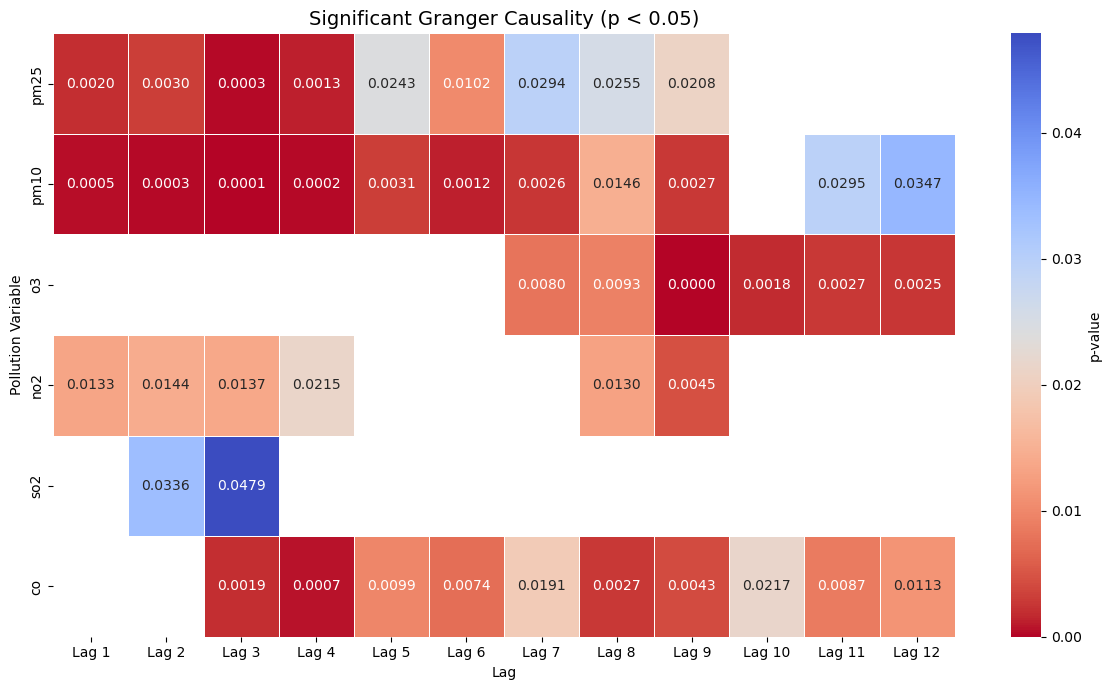

In [490]:
heatmap_data = granger_df_diff.T

# Create mask: True where p ≥ 0.05
mask = heatmap_data >= 0.05

plt.figure(figsize=(12, len(pollution_vars) * 0.5 + 4))
sns.heatmap(
    heatmap_data,
    annot=True,
    cmap='coolwarm_r',
    cbar_kws={'label': 'p-value'},
    linewidths=0.5,
    fmt=".4f",
    mask=mask  # Apply the mask
)

plt.title("Significant Granger Causality (p < 0.05)", fontsize=14)
plt.xlabel("Lag")
plt.ylabel("Pollution Variable")
plt.tight_layout()
plt.show()

In [491]:
granger_significant_vars

{'pm25': ['Lag 1',
  'Lag 2',
  'Lag 3',
  'Lag 4',
  'Lag 5',
  'Lag 6',
  'Lag 7',
  'Lag 8',
  'Lag 9'],
 'pm10': ['Lag 1',
  'Lag 2',
  'Lag 3',
  'Lag 4',
  'Lag 5',
  'Lag 6',
  'Lag 7',
  'Lag 8',
  'Lag 9',
  'Lag 11',
  'Lag 12'],
 'o3': ['Lag 7', 'Lag 8', 'Lag 9', 'Lag 10', 'Lag 11', 'Lag 12'],
 'no2': ['Lag 1', 'Lag 2', 'Lag 3', 'Lag 4', 'Lag 8', 'Lag 9'],
 'so2': ['Lag 2', 'Lag 3'],
 'co': ['Lag 3',
  'Lag 4',
  'Lag 5',
  'Lag 6',
  'Lag 7',
  'Lag 8',
  'Lag 9',
  'Lag 10',
  'Lag 11',
  'Lag 12']}

In [492]:
def create_lagged_exog(data, sig_vars_lags_dict):
    df = data.copy()
    for var, lag_list in sig_vars_lags_dict.items():
        for lag_str in lag_list:
            # Extract numeric lag from string like 'Lag 3'
            lag_num = int(lag_str.split()[1])
            df[f'{var}_lag{lag_num}'] = df[var].shift(lag_num)
    return df

# Apply lagging only for significant lags
data_lagged = create_lagged_exog(data, granger_significant_vars)
data_lagged.dropna(inplace=True)

In [493]:
data_lagged

,coalindx,pm25,pm10,o3,no2,so2,co,pm25_lag1,pm25_lag2,pm25_lag3,...,co_lag3,co_lag4,co_lag5,co_lag6,co_lag7,co_lag8,co_lag9,co_lag10,co_lag11,co_lag12
date,,,,,,,,,,,,,,,,,,,,,
2024-03-01,399.330,101.903226,52.483871,39.354839,19.258065,3.677419,6.580645,87.833333,74.096774,74.900000,...,4.533333,3.774194,4.258065,3.666667,4.258065,4.466667,7.206897,5.806452,6.300000,5.225806
2023-12-01,414.310,122.129032,58.774194,22.935484,25.064516,3.709677,8.032258,101.903226,87.833333,74.096774,...,4.064516,4.533333,3.774194,4.258065,3.666667,4.258065,4.466667,7.206897,5.806452,6.300000
2023-11-01,414.000,97.833333,51.100000,35.300000,20.500000,3.400000,6.400000,122.129032,101.903226,87.833333,...,5.533333,4.064516,4.533333,3.774194,4.258065,3.666667,4.258065,4.466667,7.206897,5.806452
2023-10-01,388.750,80.516129,35.612903,51.838710,15.064516,2.451613,5.290323,97.833333,122.129032,101.903226,...,6.580645,5.533333,4.064516,4.533333,3.774194,4.258065,3.666667,4.258065,4.466667,7.206897
2023-09-01,392.980,70.466667,28.333333,45.666667,11.333333,1.933333,5.566667,80.516129,97.833333,122.129032,...,8.032258,6.580645,5.533333,4.064516,4.533333,3.774194,4.258065,3.666667,4.258065,4.466667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-01,306.660,97.419355,45.096774,59.032258,15.193548,4.483871,5.225806,95.903226,84.800000,107.774194,...,6.516129,8.966667,9.806452,5.000000,5.633333,6.000000,5.333333,5.741935,5.161290,5.600000
2015-06-01,326.720,99.933333,49.233333,56.166667,19.633333,4.733333,5.766667,97.419355,95.903226,84.800000,...,6.033333,6.516129,8.966667,9.806452,5.000000,5.633333,6.000000,5.333333,5.741935,5.161290
2015-05-01,309.390,110.903226,52.774194,51.548387,19.387097,5.774194,5.612903,99.933333,97.419355,95.903226,...,6.258065,6.033333,6.516129,8.966667,9.806452,5.000000,5.633333,6.000000,5.333333,5.741935


In [494]:
granger_significant_vars

{'pm25': ['Lag 1',
  'Lag 2',
  'Lag 3',
  'Lag 4',
  'Lag 5',
  'Lag 6',
  'Lag 7',
  'Lag 8',
  'Lag 9'],
 'pm10': ['Lag 1',
  'Lag 2',
  'Lag 3',
  'Lag 4',
  'Lag 5',
  'Lag 6',
  'Lag 7',
  'Lag 8',
  'Lag 9',
  'Lag 11',
  'Lag 12'],
 'o3': ['Lag 7', 'Lag 8', 'Lag 9', 'Lag 10', 'Lag 11', 'Lag 12'],
 'no2': ['Lag 1', 'Lag 2', 'Lag 3', 'Lag 4', 'Lag 8', 'Lag 9'],
 'so2': ['Lag 2', 'Lag 3'],
 'co': ['Lag 3',
  'Lag 4',
  'Lag 5',
  'Lag 6',
  'Lag 7',
  'Lag 8',
  'Lag 9',
  'Lag 10',
  'Lag 11',
  'Lag 12']}

In [495]:
data_lagged.columns

Index(['coalindx', 'pm25', 'pm10', 'o3', 'no2', 'so2', 'co', 'pm25_lag1',
       'pm25_lag2', 'pm25_lag3', 'pm25_lag4', 'pm25_lag5', 'pm25_lag6',
       'pm25_lag7', 'pm25_lag8', 'pm25_lag9', 'pm10_lag1', 'pm10_lag2',
       'pm10_lag3', 'pm10_lag4', 'pm10_lag5', 'pm10_lag6', 'pm10_lag7',
       'pm10_lag8', 'pm10_lag9', 'pm10_lag11', 'pm10_lag12', 'o3_lag7',
       'o3_lag8', 'o3_lag9', 'o3_lag10', 'o3_lag11', 'o3_lag12', 'no2_lag1',
       'no2_lag2', 'no2_lag3', 'no2_lag4', 'no2_lag8', 'no2_lag9', 'so2_lag2',
       'so2_lag3', 'co_lag3', 'co_lag4', 'co_lag5', 'co_lag6', 'co_lag7',
       'co_lag8', 'co_lag9', 'co_lag10', 'co_lag11', 'co_lag12'],
      dtype='object')

In [496]:
# Define target and exogenous features based on actual Granger-significant lags
target = 'coalindx'
exog_features = []

for var, lag_list in granger_significant_vars.items():
    for lag_str in lag_list:
        lag_num = int(lag_str.split()[1])
        exog_features.append(f'{var}_lag{lag_num}')

# Build X and y
X = data_lagged[exog_features]
y = data_lagged[target]

In [497]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np

# Sort chronologically
X = X.sort_index()
y = y.sort_index()

# Then split
train_size = int(len(y) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [498]:
print("Train range:", y_train.index.min(), "→", y_train.index.max())
print("Test range:", y_test.index.min(), "→", y_test.index.max())


Train range: 2015-03-01 00:00:00 → 2022-05-01 00:00:00
Test range: 2022-06-01 00:00:00 → 2024-03-01 00:00:00


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.1

SARIMAX RMSE (filtered exog): 35.81


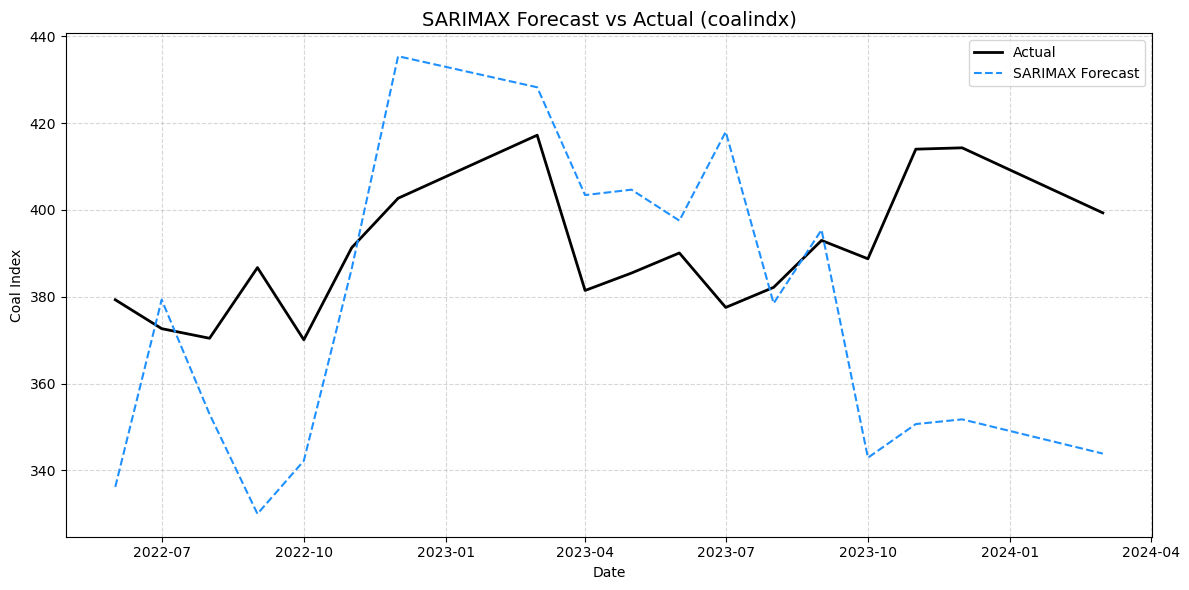

In [499]:

# Fit SARIMAX
sarimax_model = SARIMAX(y_train, exog=X_train, order=(1,1,1), seasonal_order=(1,1,1,12))
sarimax_result = sarimax_model.fit(disp=False)

# Forecast
y_pred_sarimax = sarimax_result.forecast(steps=len(y_test), exog=X_test)

# Evaluation
sarimax_rmse = np.sqrt(mean_squared_error(y_test, y_pred_sarimax))
print(f"SARIMAX RMSE (filtered exog): {sarimax_rmse:.2f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual', color='black', linewidth=2)
plt.plot(y_test.index, y_pred_sarimax, label='SARIMAX Forecast', color='dodgerblue', linestyle='--')
plt.title("SARIMAX Forecast vs Actual (coalindx)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Coal Index")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [510]:
import numpy as np
import pandas as pd
from datetime import timedelta

In [511]:
last_date = data_lagged.index.max()
forecast_end_date = pd.to_datetime('2030-12-01')  # Adjust freq to your data
future_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1),
                             end=forecast_end_date, freq='MS')
forecast_steps = len(future_dates)

In [512]:
exog_features = []
for var, lags in granger_significant_vars.items():
    for lag_str in lags:
        lag_num = int(lag_str.split()[-1])  # Extract lag number from string
        exog_features.append(f'{var}_lag{lag_num}')

In [513]:
recent_data = data_lagged[exog_features].tail(12)  # Last year
sim_means = recent_data.mean()
sim_stds = recent_data.std()

In [514]:
np.random.seed(42)  # For reproducibility

In [515]:
# Simulate future exogenous data
future_exog_data = {
    col: np.random.normal(loc=sim_means[col], scale=sim_stds[col], size=forecast_steps)
    for col in exog_features
}
future_exog = pd.DataFrame(future_exog_data, index=future_dates)

# Forecast using SARIMAX model
future_forecast = sarimax_result.forecast(steps=forecast_steps, exog=future_exog)
future_forecast.index = future_dates  # Assign correct datetime index

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


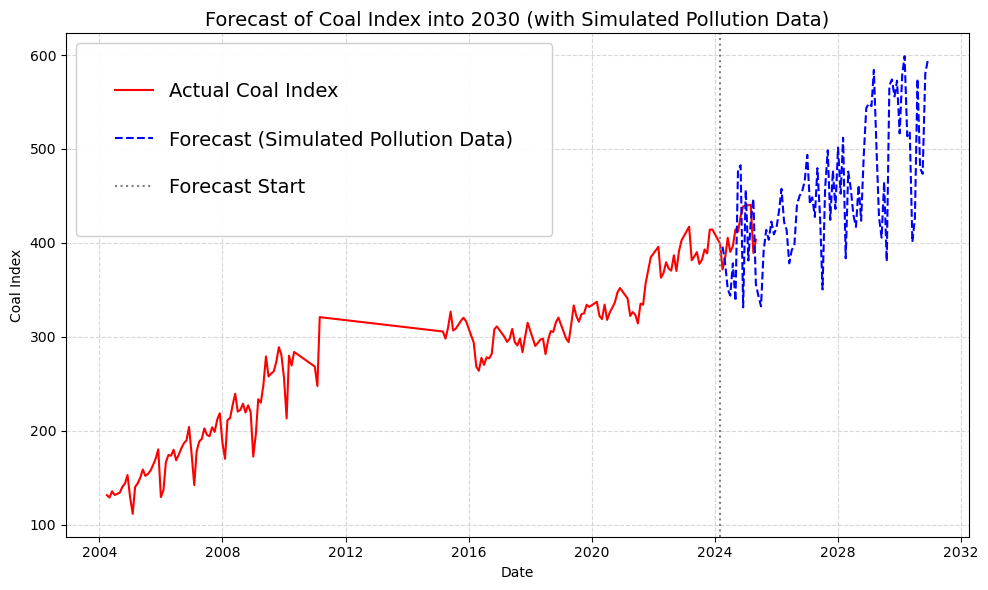

In [523]:
# Plot
plt.figure(figsize=(10,6))
plt.plot(coal.coalindx, label='Actual Coal Index', color='red')
plt.plot(future_forecast, label='Forecast (Simulated Pollution Data)', linestyle='--', color='blue')
plt.axvline(x=last_date, color='gray', linestyle=':', label='Forecast Start')
plt.title("Forecast of Coal Index into 2030 (with Simulated Pollution Data)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Coal Index")
plt.legend()

# Enhanced & enlarged legend
plt.legend(
    fontsize=14,         # Bigger text
    loc='best',          # Smart placement
    frameon=True,        
    fancybox=True,
    framealpha=0.95,
    borderpad=2.0,       # More padding inside the box
    labelspacing=1.5     # Space between entries
)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


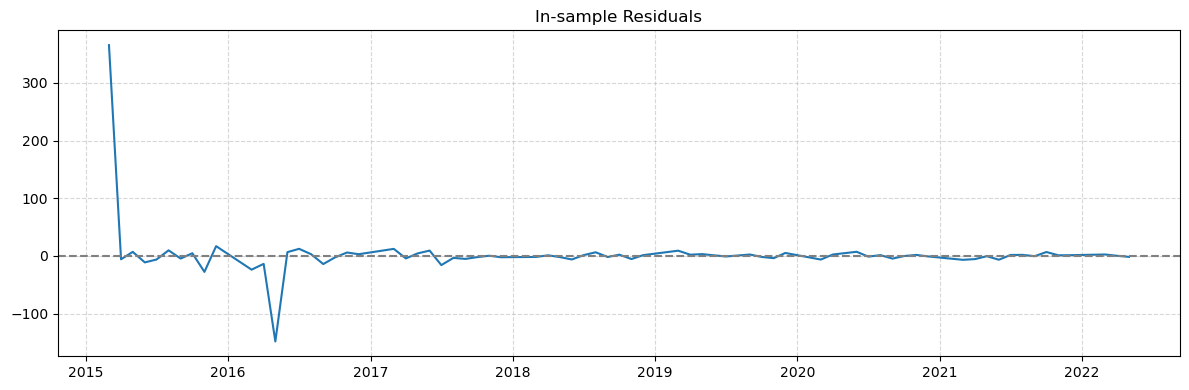

In-sample MAE: 12.14


In [517]:
from sklearn.metrics import mean_absolute_error
import numpy as np

residuals = y_train - sarimax_result.fittedvalues

plt.figure(figsize=(12, 4))
plt.plot(residuals)
plt.title("In-sample Residuals")
plt.axhline(0, color='gray', linestyle='--')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print(f"In-sample MAE: {mean_absolute_error(y_train, sarimax_result.fittedvalues):.2f}")


In [518]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Train/test split (train = 2015–2022, test = 2023–2024)
train = data[data.index < '2023-01']
test = data[data.index >= '2023-01']

# Scale
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)
scaled = pd.DataFrame(scaled, index=data.index, columns=data.columns)

train_scaled = scaled.loc[train.index]
test_scaled = scaled.loc[test.index]

# Sequence creation for LSTM
def create_sequences(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(time_steps, len(X)):
        Xs.append(X[i-time_steps:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(train_scaled[exog_vars].values,
                                            train_scaled[target].values, time_steps=3)
X_test_seq, y_test_seq = create_sequences(test_scaled[exog_vars].values,
                                          test_scaled[target].values, time_steps=3)

# Build LSTM
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=16, verbose=0)

# Forecast
y_pred_scaled = model.predict(X_test_seq)

# Inverse scale
dummy_pred = np.zeros((len(y_pred_scaled), scaled.shape[1]))
dummy_pred[:, scaled.columns.get_loc(target)] = y_pred_scaled.flatten()
y_pred = scaler.inverse_transform(dummy_pred)[:, scaled.columns.get_loc(target)]

dummy_true = np.zeros((len(y_test_seq), scaled.shape[1]))
dummy_true[:, scaled.columns.get_loc(target)] = y_test_seq.flatten()
y_test_actual = scaler.inverse_transform(dummy_true)[:, scaled.columns.get_loc(target)]

# Align dates
aligned_dates = test.index[-len(y_pred):]

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


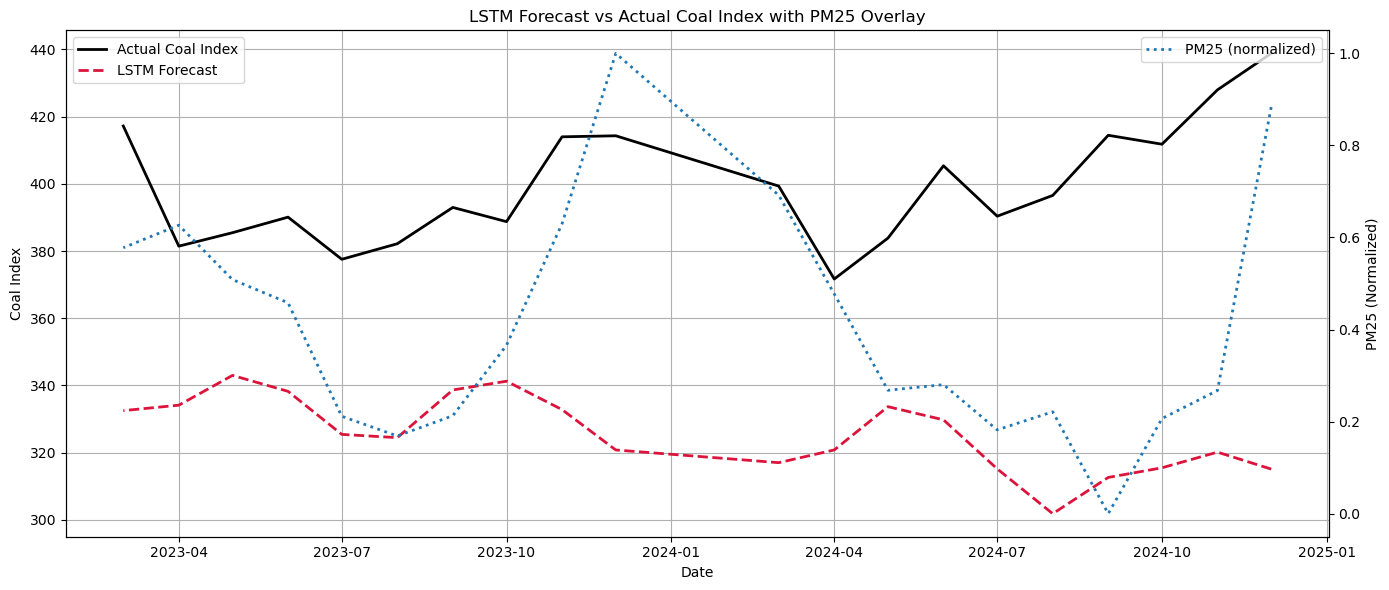

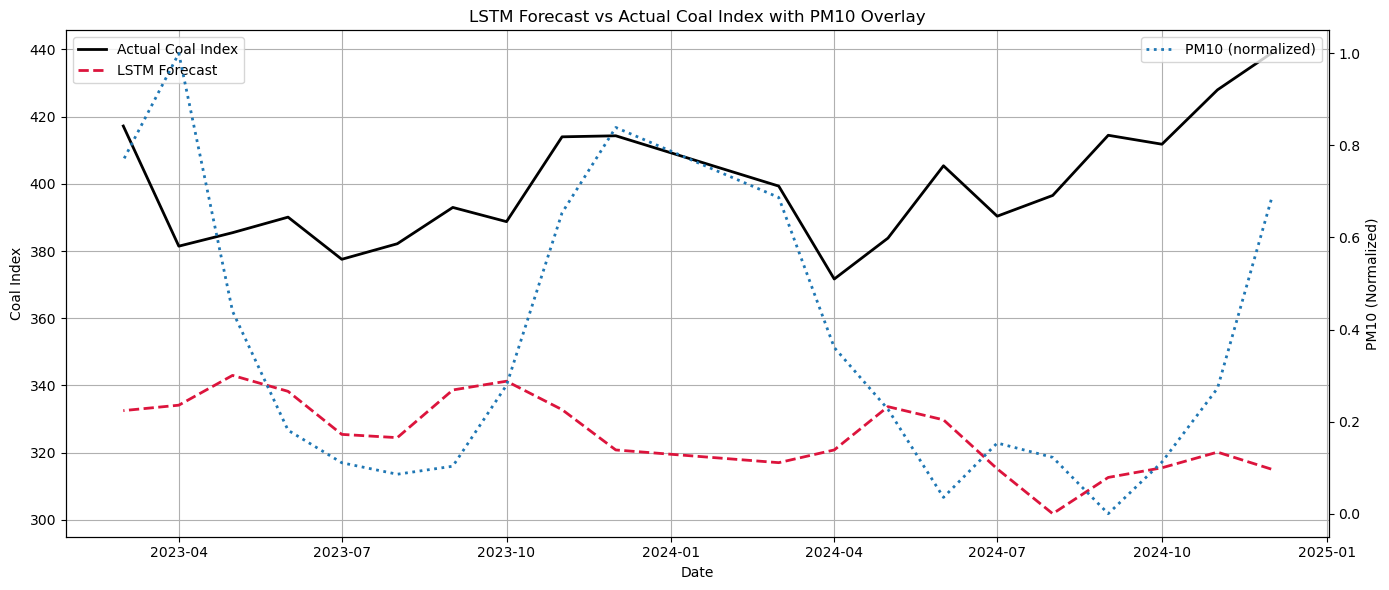

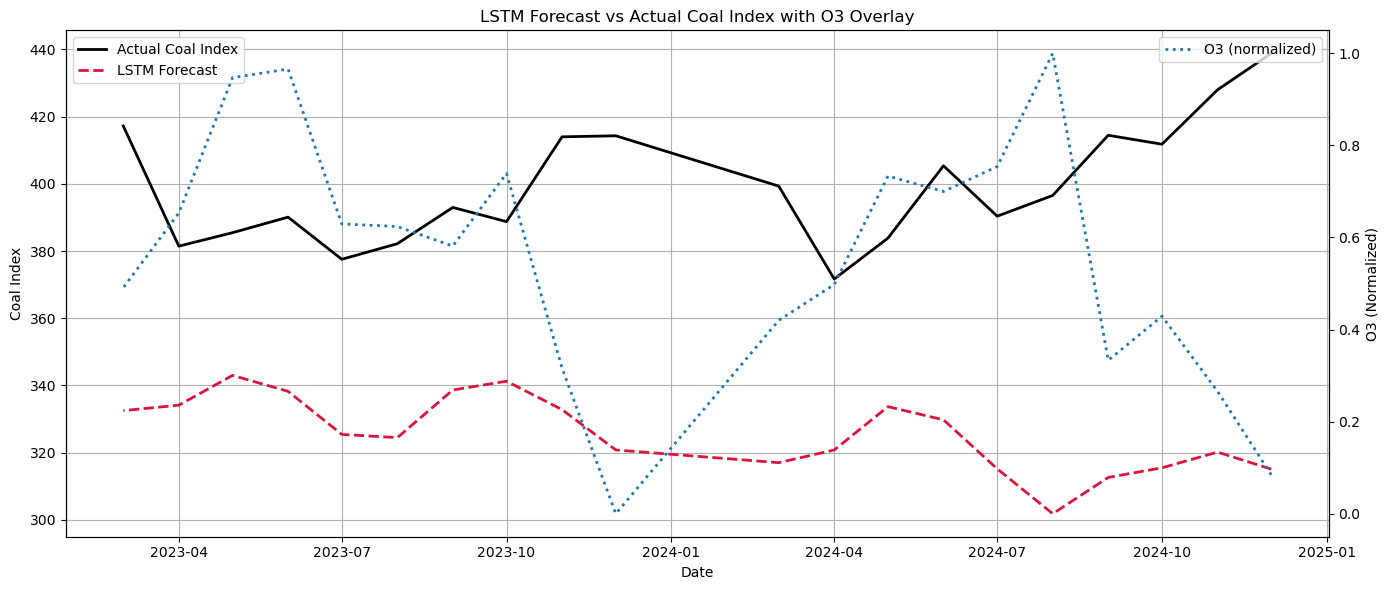

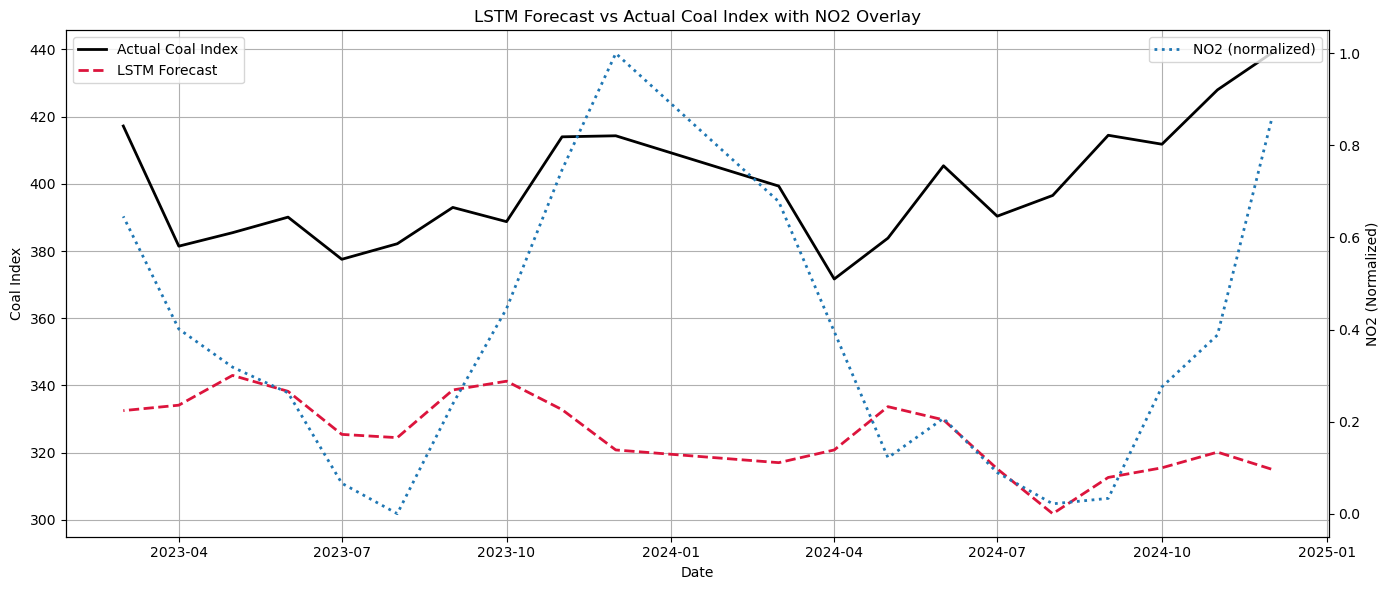

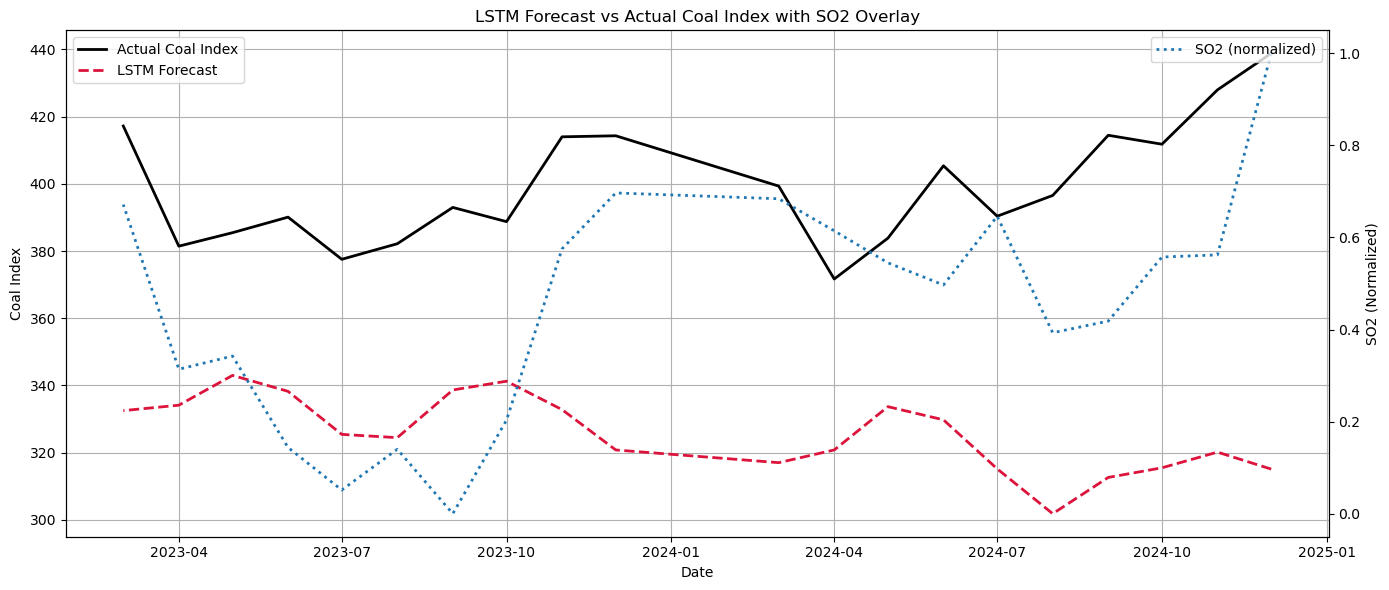

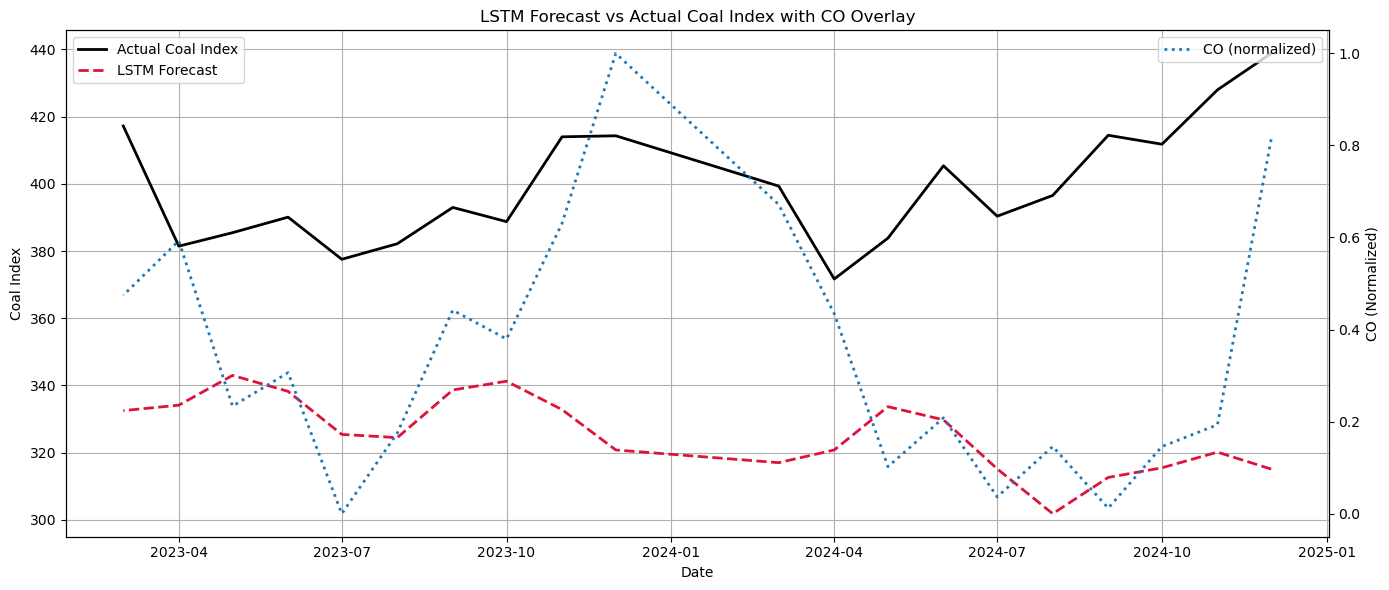

In [519]:
import matplotlib.pyplot as plt

for pollutant in pollution_vars:
    fig, ax1 = plt.subplots(figsize=(14, 6))

    # Left axis: Coal index
    ax1.plot(aligned_dates, y_test_actual, label="Actual Coal Index", color="black", linewidth=2)
    ax1.plot(aligned_dates, y_pred, label="LSTM Forecast", color="crimson", linestyle="--", linewidth=2)
    ax1.set_ylabel("Coal Index")
    ax1.set_xlabel("Date")
    ax1.legend(loc="upper left")
    ax1.grid(True)

    # Right axis: Normalized pollutant
    ax2 = ax1.twinx()
    pollutant_series = test[pollutant].iloc[-len(y_pred):]
    pollutant_norm = MinMaxScaler().fit_transform(pollutant_series.values.reshape(-1, 1)).flatten()
    ax2.plot(aligned_dates, pollutant_norm, label=f"{pollutant.upper()} (normalized)",
             color="tab:blue", linestyle="dotted", linewidth=2)
    ax2.set_ylabel(f"{pollutant.upper()} (Normalized)")
    ax2.legend(loc="upper right")

    plt.title(f"LSTM Forecast vs Actual Coal Index with {pollutant.upper()} Overlay")
    plt.tight_layout()
    plt.show()
